# CMIP6 Earth System Model example

Grid-aware operations such as average, integrate and cumulative integration rely on user-provided [grid metrics](https://xgcm.readthedocs.io/en/latest/grid_metrics.html). This notebook demonstrates the methods `interp_like()`, `get_metric()`, and `set_metrics()` which makes working with metrics easier, better, faster, and shorter when processing ocean models such as CMIP6 Earth System Models. The main objective of this notebook is to calculate and plot the time series of area-averaged temperature and zonal velocity from an ESM.

## Setting up the sample dataset

First, we import the packages we need for this example. To run a piece of code, click on the cell and hit `Shift` + `Enter`.

In [1]:
import intake
import matplotlib as plt
import xarray as xr
import numpy as np
import cftime
import dask

In [2]:
!python -m pip install git+https://github.com/xgcm/xgcm.git
import xgcm
xgcm.__version__

  Cloning https://github.com/xgcm/xgcm.git to /tmp/pip-req-build-owswiym0
  Running command git clone -q https://github.com/xgcm/xgcm.git /tmp/pip-req-build-owswiym0
  Running command git submodule update --init --recursive -q


'0.5.3.dev24+g6e68f71'

In [3]:
from dask_gateway import GatewayCluster
cluster = GatewayCluster()
cluster.adapt(minimum=2, maximum=10) 
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.ddede8e4688d4a85b02fd03ed277658e Dashboard: /services/dask-gateway/clusters/prod.ddede8e4688d4a85b02fd03ed277658e/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Next, we download temperature (`thetao`), zonal velocity (`uo`) and horizontal area (`areacello`) for the CNRM-ESM2-1 model, just one example of an [Earth System Model](https://pcmdi.llnl.gov/CMIP6/ArchiveStatistics/esgf_data_holdings/). ESMs are global, 4-dimensional, coupled ocean-atmosphere-biogeochemical models commonly used to evaluate the effects of increased atmospheric carbon dioxide concentrations on planetary processes. Check out [this page](https://www.carbonbrief.org/cmip6-the-next-generation-of-climate-models-explained) for further information. In this example, we are using historical data from 1850 to 2014, but we can change the code to download [model results from 2015 to 2100](https://www.carbonbrief.org/explainer-how-shared-socioeconomic-pathways-explore-future-climate-change) under high to low climate change mitigation scenarios, so feel free to explore! The latest version of these datasets are under CMIP6 and are hosted in the cloud by the [Pangeo project](https://pangeo.io/). 

In [4]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(
    source_id = 'CNRM-ESM2-1', # use a different source ID if you want to try other models
    member_id = 'r1i1p1f2', # common values are r1i1p1f1 or r1i1p1f2
    experiment_id = 'historical', # other possible inputs: ssp126, ssp370, and ssp585 
    variable_id= ['thetao','uo','areacello'],
    grid_label = 'gn', # common values are gn or gr 
    
)
ddict = cat.to_dataset_dict(zarr_kwargs={'consolidated':True, 'use_cftime':True}, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
ddict.keys()

dict_keys(['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Ofx/areacello/gn/v20181206/.nan.20181206', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.uo.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/uo/gn/v20181206/.nan.20181206', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/thetao/gn/v20181206/.nan.20181206'])

We manually extract thetao, uo and areacello so we can do subsetting and renaming before we save the datasets into one array.

In [6]:
thetao = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.thetao.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/thetao/gn/v20181206/.nan.20181206'].thetao
uo = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Omon.uo.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Omon/uo/gn/v20181206/.nan.20181206'].uo
areacello = ddict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.r1i1p1f2.Ofx.areacello.gn.gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/historical/r1i1p1f2/Ofx/areacello/gn/v20181206/.nan.20181206'].areacello

We can see that the uo grid is shifted to the right along the x-axis (`lon`) compared to thetao.

<function matplotlib.pyplot.show(close=None, block=None)>

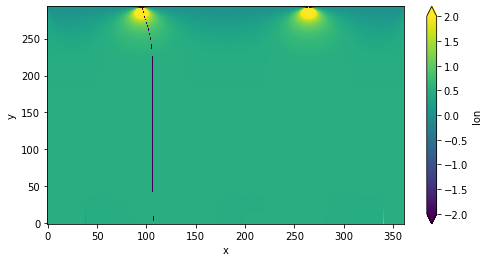

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
diff = uo.lon-thetao.lon
diff.plot(vmin=-2,vmax=2)
plt.show

We assign areacello as a coordinate for thetao since they are on a similar grid.

In [8]:
thetao = thetao.assign_coords(areacello=areacello.reset_coords(drop=True).fillna(0)) # drop areacello lat/lon coordinates, fill missing values with 0

Now we subset our preferred patch of ocean from the global datasets. For now the domain limits are set to the California Current, but you can adjust lat_north, lat_south, lon_west, and lon_east to your liking. As you change these values, make sure `subset_thetao` and `subset_uo` are the same size (see cell below). To do that, we recommend changing the longitude/latitude values incrementally by 0.25 deg until you get a satisfactory domain size.

Additionally, CNRM-ESM2-1 uses negative values east of the IDL (i.e., 130 W is -130), and this can vary per model so if you change `source_id` in the beginning, make sure you know which longitude convention that model uses. We also do surface plots to make sure we did the subsetting correctly.

In [9]:
lat_north = 50
lat_south = 25
lon_west = -130
lon_east = -110.75

subset_thetao = thetao.where((thetao.lat > lat_south) & (thetao.lat < lat_north) & (thetao.lon > lon_west) & (thetao.lon < lon_east), drop=True)
subset_uo = uo.where((uo.lat > lat_south) & (uo.lat < lat_north) & (uo.lon > lon_west) & (uo.lon < lon_east), drop=True)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(sl

Replace `subset_thetao` in the cell below with `subset_uo` to double-check if subset_thetao and subset_uo are the same size (e.g., the 'x' and 'y' values for variables such as 'lat' and 'lon' should be equal, and for this example `y: 38`, `x: 20`).

In [10]:
subset_thetao

<xarray.DataArray 'thetao' (time: 1980, lev: 75, y: 38, x: 20)>
dask.array<where, shape=(1980, 75, 38, 20), dtype=float32, chunksize=(4, 75, 38, 20), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lon        (y, x) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    areacello  (y, x) float32 dask.array<chunksize=(38, 20), meta=np.ndarray>
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         Diagnostic should be contributed even for models usi...
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Sea Water Potential Temperature
    online_operation:    average
    standard_name:       sea_water_potential_temperature
    units:               degC

Plot the zonal velocity subset.

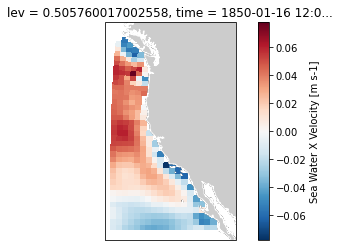

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.Mercator())
subset_uo.isel(lev=0,time=0).squeeze().plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
ax.coastlines()
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)

Plot the temperature subset.

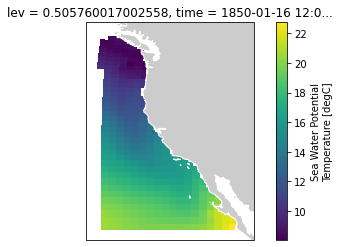

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())
subset_thetao.isel(lev=0,time=0).squeeze().plot.pcolormesh(ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree())
coast_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='w', facecolor='0.8')
ax.add_feature(coast_10m)

Since `uo` is shifted to the right compared to `thetao`, we rename its coordinates (such that `thetao` coordinates will be referred to as 'x', 'lon', and 'lat').

In [13]:
subset_uo = subset_uo.rename({'x':'x_c','lon':'lon_u', 'lat':'lat_u'})

After renaming, we can merge the datasets into one DataArray using `xarray.merge`.

In [14]:
ds_subset = xr.merge([subset_thetao, subset_uo], compat='override')
ds_subset

<xarray.Dataset>
Dimensions:    (lev: 75, time: 1980, x: 20, x_c: 20, y: 38)
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
  * lev        (lev) float64 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lon        (y, x) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    areacello  (y, x) float32 dask.array<chunksize=(38, 20), meta=np.ndarray>
    lat_u      (y, x_c) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
    lon_u      (y, x_c) float64 dask.array<chunksize=(38, 20), meta=np.ndarray>
Dimensions without coordinates: x, x_c, y
Data variables:
    thetao     (time, lev, y, x) float32 dask.array<chunksize=(4, 75, 38, 20), meta=np.ndarray>
    uo         (time, lev, y, x_c) float32 dask.array<chunksize=(3, 75, 38, 20), meta=np.ndarray>

If we look more closely, the dimensions of temperature and zonal velocity are now different. Take note that the metrics used for each variable when doing grid-aware operations should match. This means we can use `areacello` for temperature, but what about for the zonal velocity? (Stay tuned!)

In [15]:
print(ds_subset.thetao.dims)
print(ds_subset.areacello.dims)
print(ds_subset.uo.dims)

('time', 'lev', 'y', 'x')
('y', 'x')
('time', 'lev', 'y', 'x_c')


## Plot a time series of average surface temperature data from CNRM-ESM2-1

Calculating average temperature over time is straightforward since we have the metric `areacello` with the right axes `("X","Y")` and dimensions `(x, y)`. The xgcm package uses a `Grid` class, and so first we create a `grid` object which contains our dataset `ds_subset` and assign parameters such as metrics. Then we perform a grid-weighted `average` based on this `grid` object, and plot the result as a time series.

In [16]:
from xgcm import Grid
grid = Grid(
    ds_subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello'}
)
grid._metrics

{frozenset({'X',
            'Y'}): [<xarray.DataArray 'areacello' (y: 38, x: 20)>
  dask.array<getitem, shape=(38, 20), dtype=float32, chunksize=(38, 20), chunktype=numpy.ndarray>
  Dimensions without coordinates: y, x
  Attributes:
      cell_methods:      area: sum
      description:       Cell areas for any grid used to report ocean variables...
      history:           none
      long_name:         Grid-Cell Area
      online_operation:  once
      standard_name:     cell_area
      units:             m2]}

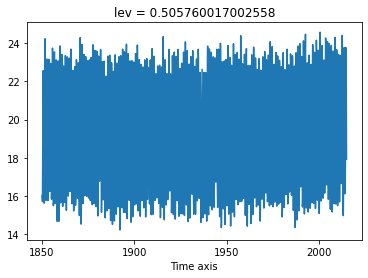

In [17]:
mean_sst = grid.average(ds_subset.thetao.isel(lev=0),['X','Y'])
mean_sst.plot()

## Plot a time series of average surface zonal velocity data from CNRM-ESM2-1

In previous versions of `xgcm`, trying to plot u-velocity the way we did with temperature would have failed, because we did not provide metrics at the right dimensions. (Recall that along the x-axis, areacello is at 'x', while uo is at 'x_c').

![xgcm-version](xgcm-version.png)

![average-uo.png](average-uo.png)

To do it successfully, we would have had to do it the long way: create a `grid` object with `areacello` as a metric, interpolate the area metric to the u-velocity grid (`areacello_uo`), create another grid object with updated metrics, then calculate the `average`.

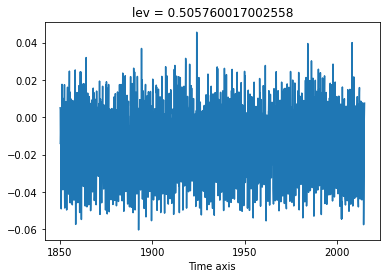

In [18]:
from xgcm import Grid

# Step 1: Create a grid object with the available metric
grid = Grid(
    ds_subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello'}
)

# Step 2: Interpolate the available metric to the desired variable grid and assign it as a coordinate
areacello_uo = grid.interp(ds_subset.areacello,("X")) 
ds_subset = ds_subset.assign_coords(areacello_uo=areacello_uo.reset_coords(drop=True).fillna(0))

# Step 3: Create a new grid object 
grid_demo = Grid(
    ds_subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
    metrics={('X','Y'): 'areacello_uo'}
)

# Step 4: Calculate the average and plot the time series
mean_uo_demo = grid_demo.average(ds_subset.uo.isel(lev=0),['X','Y'])
mean_uo_demo.plot()

But now we can do it the short way! With the addition of `interp_like`, and updated versions of `get_metric` and `set_metrics`, we can use the exact same lines of code as we did for calculating the temperature time series (do it in 1 step vs 4 steps).

/srv/conda/envs/notebook/lib/python3.8/site-packages/xgcm/grid.py:1363: UserWarning: Metric at ('time', 'y', 'x_c') being interpolated from metrics at dimensions ('y', 'x'). Boundary value set to 'extend'.
  warnings.warn(


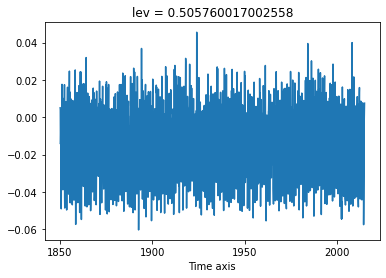

In [19]:
mean_uo = grid.average(ds_subset.uo.isel(lev=0),['X','Y'])
mean_uo.plot()

### Demonstrating updated functionality for the xgcm package

Let's take a closer look at how and why this worked. Since our available horizontal area metric (areacello) is in temperature dimensions, to get the metric for the u-velocity grid, we need to interpolate areacello to u-velocity dimensions. We can use the `interp_like` method or `get_metric` (which uses `interp_like` "under the hood"). For this example, the inputs for `interp_like` are the available metric ("ds_subset.areacello") and the array you need a metric for ("ds_subset.uo"). The inputs for `get_metric` are the array you need a metric for ("ds_subset.uo") and the axes to interpolate it to (("X","Y")). The method will use the metric available on the ("X","Y") axis already assigned to the grid object ("areacello") for the interpolation.

In [20]:
areacello_uo = grid.interp_like(ds_subset.areacello,ds_subset.uo)
areacello_uo_getmetric = grid.get_metric(ds_subset.uo,("X","Y"))

/srv/conda/envs/notebook/lib/python3.8/site-packages/xgcm/grid.py:1363: UserWarning: Metric at ('time', 'lev', 'y', 'x_c') being interpolated from metrics at dimensions ('y', 'x'). Boundary value set to 'extend'.
  warnings.warn(


Double-check if the interpolated metrics are equal.

In [21]:
equal_metric = xr.testing.assert_equal(areacello_uo,areacello_uo_getmetric) # raises an assertion error if two objects are not equal
print(equal_metric)

None


Now that we have this interpolated metric, we can update the grid object with `set_metrics`. Take note at this point that if you just want to do grid-aware operations such as `average`, `integrate` and `cumint`, they already use `get_metric` internally. There's no need to update the metrics through `set_metrics`, this is just to show how this method can give you a level of flexibility when you are experimenting with getting the right metrics for your dataset.

In [22]:
# Step 1: Assign areacello_uo as a coordinate of subset so that you can assign it as a metric 
subset = ds_subset.assign_coords(areacello_uo=areacello_uo.reset_coords(drop=True).fillna(0)) # fill missing values with 0

# Step 2: Create an updated grid object
grid_updated = Grid(
    subset,
    coords={
        'X':{'center':'x', 'right':'x_c'},
        'Y':{'center':'y', 'right':'y_c'},
        'Z':{'center':'lev'},
    },
    periodic=False,
    boundary='extend',
)

# Step 3a: Assign areacello_uo as a metric. 
grid_updated.set_metrics(('X','Y'),'areacello_uo')

# Step 3b: Take note that with set_metrics you can assign multiple metrics on the same axes to your dataset as long as they have different dimensions.
grid_updated.set_metrics(('X','Y'),'areacello')

# Step 4: Double check if the metrics were assigned
grid_updated._metrics

{frozenset({'X',
            'Y'}): [<xarray.DataArray 'areacello_uo' (y: 38, x_c: 20)>
  dask.array<where, shape=(38, 20), dtype=float32, chunksize=(38, 19), chunktype=numpy.ndarray>
  Dimensions without coordinates: y, x_c, <xarray.DataArray 'areacello' (y: 38, x: 20)>
  dask.array<getitem, shape=(38, 20), dtype=float32, chunksize=(38, 20), chunktype=numpy.ndarray>
  Dimensions without coordinates: y, x
  Attributes:
      cell_methods:      area: sum
      description:       Cell areas for any grid used to report ocean variables...
      history:           none
      long_name:         Grid-Cell Area
      online_operation:  once
      standard_name:     cell_area
      units:             m2]}

### Confirm that we get the same temperature and u-velocity time series with this updated grid object.

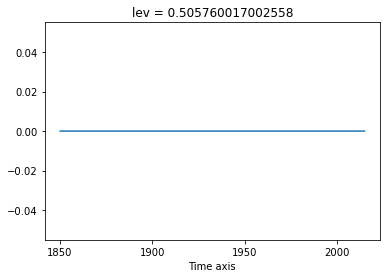

In [23]:
mean_sst_updated = grid_updated.average(subset.thetao.isel(lev=0),['X','Y'])
diff_sst = mean_sst-mean_sst_updated
diff_sst.plot()

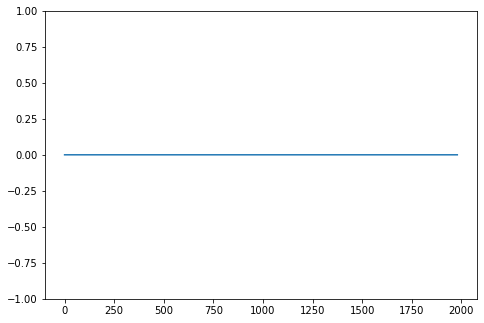

In [24]:
mean_uo_updated = grid_updated.average(subset.uo.isel(lev=0),['X','Y'])
diff_uo = mean_uo-mean_uo_updated

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
ax.plot(diff_uo)
ax.set_ylim(-1,1)
plt.show()